# Optimizing Accuracy with Noise-Aware Transpilation  

### Overview
This notebook focuses on reducing error in noisy quantum simulations using Qiskit’s noise-aware transpiler.

### Goals:
- Investigate how Qiskit's transpilation levels affect accuracy under noise.
- Use Total Variation Distance (TVD) to compare noisy results with ideal results.
- Compare different transpilation optimization levels (0, 1, 2, 3).

STEP 1: Define Hadamard-Based Quantum Walk Circuit for A Given Depth

In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, binom
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import warnings
warnings.filterwarnings('ignore')

import os
# Create output directory
output_dir = "../outputs/Derivable4b/"
os.makedirs(output_dir, exist_ok=True)  # Create if doesn't exist

In [2]:
def build_hadamard_walk(n_layers):
    """
    Constructs a quantum walk circuit using Hadamard gates.

    Args:
        n_layers (int): Number of quantum steps (layers)

    Returns:
        QuantumCircuit: A simple Hadamard walk circuit
    """
    qr = QuantumRegister(n_layers)
    cr = ClassicalRegister(n_layers)
    qc = QuantumCircuit(qr, cr)

    for i in range(n_layers):
        qc.h(i)  # Apply Hadamard to each qubit

    qc.barrier()
    qc.measure(qr, cr)
    return qc

STEP 2: Total Variation Distance (TVD) Calculator

In [3]:
def total_variation_distance(counts1, counts2):
    """
    Calculates the TVD between two count distributions.

    Args:
        counts1 (dict): First result dict (e.g., ideal)
        counts2 (dict): Second result dict (e.g., noisy)

    Returns:
        float: TVD score
    """
    keys = set(counts1) | set(counts2)
    total1 = sum(counts1.values())
    total2 = sum(counts2.values())

    tvd = 0
    for k in keys:
        p1 = counts1.get(k, 0) / total1
        p2 = counts2.get(k, 0) / total2
        tvd += abs(p1 - p2)

    return tvd / 2

STEP 3: Simulation for Any Transpilation Level

In [4]:
def simulate(qc, shots, noise_model, optimization_level=None):
    """
    Simulates a given circuit with/without noise.

    Args:
        qc (QuantumCircuit): The quantum circuit
        shots (int): Number of shots to run
        noise_model (NoiseModel): Noise model to use
        optimization_level (int, optional): 0–3 transpilation level

    Returns:
        dict: Measured counts
    """
    sim = AerSimulator()
    transpiled = transpile(qc, sim,
                           optimization_level=optimization_level,
                           basis_gates=noise_model.basis_gates if noise_model else None)
    result = sim.run(transpiled, noise_model=noise_model, shots=shots).result()
    return result.get_counts()

STEP 4: Run Simulations

In [5]:
steps = 5
shots = 8192
qc = build_hadamard_walk(steps)

# Ideal (noiseless) simulation
ideal_counts = simulate(qc, shots=shots, noise_model=None)

# Custom noise model for realistic errors (no IBMQ needed)
noise_model = NoiseModel()

# Store TVD scores for each optimization level
tvd_results = {}

for level in range(4):
    noisy_counts = simulate(qc, shots=shots, noise_model=noise_model, optimization_level=level)
    tvd = total_variation_distance(ideal_counts, noisy_counts)
    tvd_results[f"Level {level}"] = tvd
    print(f"[Opt. Level {level}] → TVD = {tvd:.4f}")

[Opt. Level 0] → TVD = 0.0377
[Opt. Level 1] → TVD = 0.0471
[Opt. Level 2] → TVD = 0.0322
[Opt. Level 3] → TVD = 0.0372


Step 5: Plot TVD Results

[✓] Plot saved to: ../outputs/Derivable4b/tvd_vs_transpilation_level.png


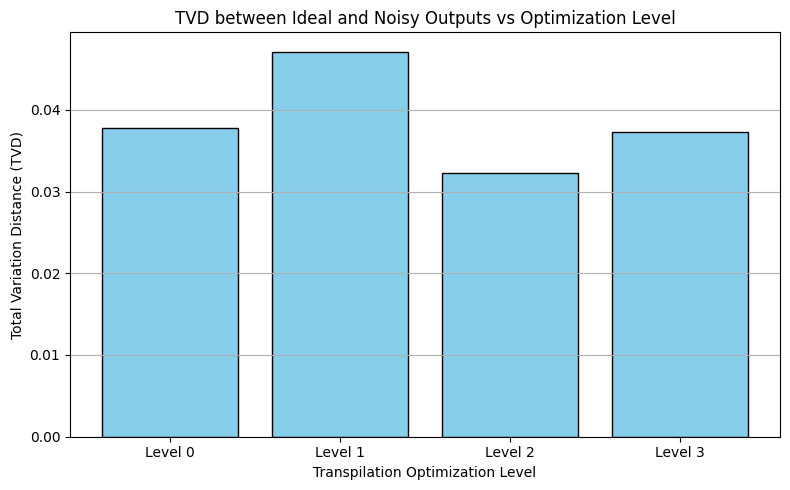

In [6]:
plt.figure(figsize=(8,5))
plt.bar(tvd_results.keys(), tvd_results.values(), color='skyblue', edgecolor='black')
plt.title("TVD between Ideal and Noisy Outputs vs Optimization Level")
plt.ylabel("Total Variation Distance (TVD)")
plt.xlabel("Transpilation Optimization Level")
plt.grid(axis='y')
plt.tight_layout()

# Save and Show
# save_path = "/home/sarojray/Downloads/womanium2025/QuantumGaltonBox/results/tvd_vs_transpilation_level.png"
# plt.savefig(save_path, dpi=300)
# print(f"[✓] Plot saved to: {save_path}")
# plt.show()

plot_path = os.path.join(output_dir, "tvd_vs_transpilation_level.png")
plt.savefig(plot_path, dpi=300)
print(f"[✓] Plot saved to: {plot_path}")
plt.show()